<a href="https://colab.research.google.com/github/angeloHowell/Computer-Vision/blob/main/detector_hair_swirl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por favor, selecciona una imagen para subir...


Saving remolino 5.png to remolino 5.png
Imagen cargada: remolino 5.png
Rotación total: 18343574.0
Área de la máscara: 4461
Rotación normalizada: 4111.986998430845


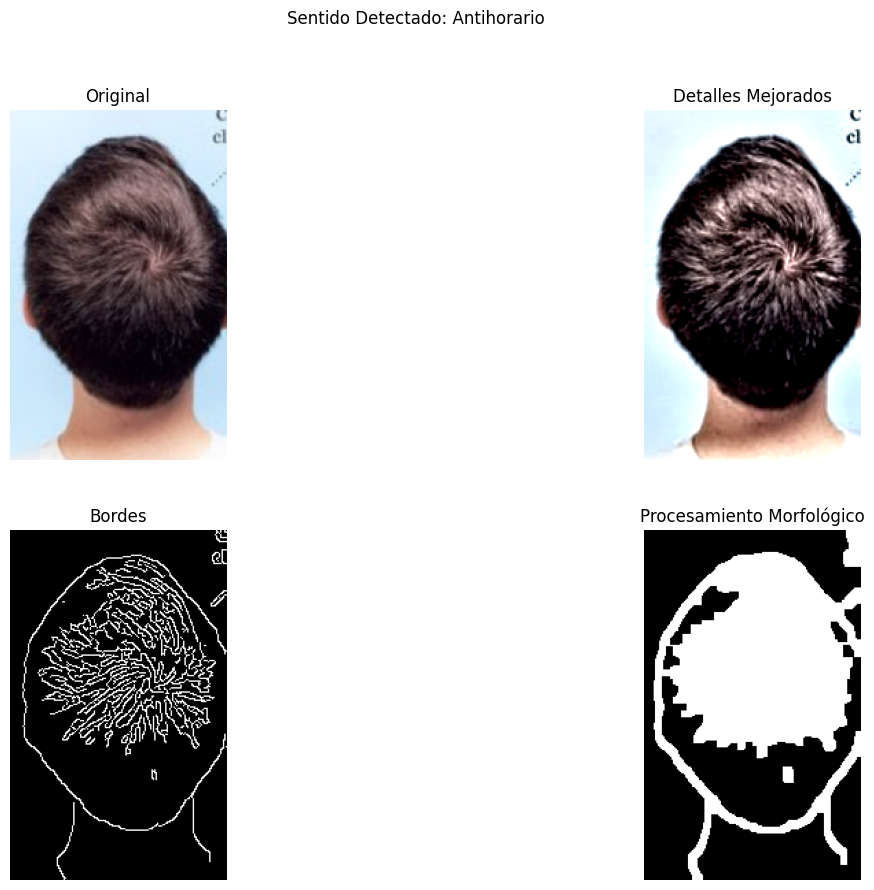

El remolino detectado es: Antihorario


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def preprocess_image(img):
    # Mejorar detalles de la imagen
    detail = cv2.detailEnhance(img, sigma_s=20, sigma_r=0.15)

    # Convertir a escala de grises
    gray = cv2.cvtColor(detail, cv2.COLOR_BGR2GRAY)

    # Aplicar filtro gaussiano
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Detección de bordes
    edges = cv2.Canny(blur, 75, 200)

    # Transformación morfológica
    kernel = np.ones((5,5), np.uint8)
    dilate = cv2.dilate(edges, kernel, iterations=1)
    closing = cv2.morphologyEx(dilate, cv2.MORPH_CLOSE, kernel)

    return detail, gray, edges, closing

def detect_swirl_direction(img):
    # Preprocesar la imagen
    detail, gray, edges, closing = preprocess_image(img)

    # Calcular gradientes usando Scharr
    grad_x = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    grad_y = cv2.Scharr(gray, cv2.CV_64F, 0, 1)

    # Calcular magnitud y ángulo
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x)

    # Crear máscara para el área central
    height, width = gray.shape
    center_y, center_x = height // 2, width // 2
    y, x = np.ogrid[:height, :width]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    radius = min(height, width) // 4
    mask = dist_from_center < radius

    # Aplicar la máscara morfológica del closing
    mask = mask & (closing > 0)

    # Calcular el patrón de rotación usando los gradientes enmascarados
    masked_grad_x = grad_x * mask
    masked_grad_y = grad_y * mask

    # Calcular la rotación usando el producto cruz de los gradientes
    rotation = np.sum(masked_grad_x[:-1, :] * masked_grad_y[1:, :] -
                     masked_grad_x[1:, :] * masked_grad_y[:-1, :])

    # Normalizar la rotación por el área de la máscara
    area = np.sum(mask)
    normalized_rotation = rotation / area if area > 0 else 0

    # Imprimir valores de diagnóstico
    print(f"Rotación total: {rotation}")
    print(f"Área de la máscara: {area}")
    print(f"Rotación normalizada: {normalized_rotation}")

    # Ajustar el umbral a un valor más apropiado
    threshold = 1e-1  # Reducido significativamente
    if abs(normalized_rotation) < threshold:
        return "No se puede determinar con certeza"

    return "Horario" if normalized_rotation < 0 else "Antihorario"

try:
    print("Por favor, selecciona una imagen para subir...")
    uploaded = files.upload()

    if not uploaded:
        print("No se seleccionó ninguna imagen")
    else:
        filename = next(iter(uploaded))
        img = cv2.imdecode(np.frombuffer(uploaded[filename], np.uint8), cv2.IMREAD_COLOR)
        print(f"Imagen cargada: {filename}")

        # Preprocesar la imagen y detectar dirección
        detail, gray, edges, closing = preprocess_image(img)
        sentido = detect_swirl_direction(img)

        # Visualización
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(detail, cv2.COLOR_BGR2RGB))
        plt.title("Detalles Mejorados")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("Bordes")
        plt.axis("off")

        plt.subplot(2, 2, 4)
        plt.imshow(closing, cmap='gray')
        plt.title("Procesamiento Morfológico")
        plt.axis("off")

        plt.suptitle(f"Sentido Detectado: {sentido}")
        plt.show()

        print(f"El remolino detectado es: {sentido}")

except KeyboardInterrupt:
    print("\nProceso de subida cancelado por el usuario")
except Exception as e:
    print(f"Ocurrió un error: {str(e)}")